### 0) 의존성 설치

In [1]:
!pip -q install safetensors evaluate seqeval scikit-learn pandas

In [2]:
!pip install -U "transformers>=4.42" "datasets>=2.20" "tokenizers>=0.19.1" "accelerate>=0.33"

In [3]:
import re, os, random, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
import math

from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict, Features, Value
from transformers import AutoTokenizer, DataCollatorWithPadding

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, AutoTokenizer

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report

from collections import Counter

### 1) 데이터 로드 & 전처리 (7개 CWE 멀티클래스)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
combined_df = pd.read_csv('/content/drive/MyDrive/KISIA/project/data/vul_data/combined_2000_labeled_dataset_fixed.csv')
# 'label' 열의 값이 1인 행 삭제
combined_df = combined_df[combined_df['label'] != 1].reset_index(drop=True)

vuln_df = pd.read_csv('/content/drive/MyDrive/KISIA/project/data/vul_data/CWE_vulset_noNaN.csv')
vuln_df = vuln_df.drop(columns=["sha", "keyword", "goodparts", "badparts", "sourceWithComments"], axis = 1)

In [6]:
# combined_df의 열 이름 변경
combined_df = combined_df.rename(columns={'source_code': 'source', 'label': 'CWE'})
df = pd.concat([combined_df[['source', 'CWE']], vuln_df[['source', 'CWE']]], ignore_index=True)

# df의 'CWE' 열에서 0을 'CLEAN'으로 바꾸기
df['CWE'] = df['CWE'].replace(0, 'CLEAN')

#섞기
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,source,CWE
0,"\n """""" Client blueprint used to handle OAuth c...",CWE-79
1,"\n\nimport psycopg2 def get_top_articles(cur, ...",CWE-89
2,"\n """""" Network Path Algorithms Between Switche...",CWE-538
3,\n from osv import osv from tools.translate im...,CWE-89
4,\nimport json import logging import os.path im...,CWE-538
...,...,...
4442,\nimport ckan.lib.base as base import ckan.lib...,CWE-601
4443,"\n\nVERSION = ""2020.1""\n\nOLSON_VERSION = ""202...",CLEAN
4444,"\n from __future__ import(absolute_import, div...",CWE-77
4445,"\n"""""" Unit tests for the Deis api app. Run the...",CWE-352


In [7]:
# 변경 확인
display(df['CWE'].value_counts())

,count
CWE,
CWE-89,1394
CWE-352,762
CLEAN,551
CWE-538,475
CWE-77,400
CWE-601,346
CWE-94,296
CWE-79,223


#### 분할

In [8]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

CODE_COL  = "source"
LABEL_COL = "CWE"

# 7종 + CLEAN
CWE_CLASSES = ['CWE-94','CWE-538','CWE-89','CWE-77','CWE-79','CWE-352','CWE-601','CLEAN']
CWE_TO_IDX = {c:i for i,c in enumerate(CWE_CLASSES)}
NUM_LABELS = len(CWE_CLASSES)

# CSV 로드
df = df[[CODE_COL, LABEL_COL]].dropna(subset=[CODE_COL, LABEL_COL]).copy()

# 라벨 정규화: 7종이 아니면 CLEAN
df["label_norm"] = df[LABEL_COL].astype(str).str.strip()
df.loc[~df["label_norm"].isin(list(CWE_TO_IDX.keys())), "label_norm"] = "CLEAN"

df["label_idx"] = df["label_norm"].map(CWE_TO_IDX).astype(int)

print(df["label_norm"].value_counts())

# 간단 코드 정규화
def simple_normalize(code: str) -> str:
    return str(code).replace("\t","    ").replace("\r\n","\n").replace("\r","\n")
df[CODE_COL] = df[CODE_COL].apply(simple_normalize)

# 분할: StratifiedShuffleSplit 사용 (한 번에 train/val/test)
MIN_PER_CLASS = 10

class_counts = df["label_idx"].value_counts()
min_count = class_counts.min()
print("라벨별 최소 카운트:", min_count)

try:
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, temp_idx = next(sss1.split(df, df["label_idx"]))
    temp_df = df.iloc[temp_idx].reset_index(drop=True)
    train_df = df.iloc[train_idx].reset_index(drop=True)

    # temp -> val/test 반으로 나누기 (stratified)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
    val_idx_rel, test_idx_rel = next(sss2.split(temp_df, temp_df["label_idx"]))
    val_df = temp_df.iloc[val_idx_rel].reset_index(drop=True)
    test_df = temp_df.iloc[test_idx_rel].reset_index(drop=True)
except ValueError as e:
    # stratify 실패 시 (샘플 부족) 비계층으로 폴백
    print("Stratified split 실패:", e)
    print("-> shuffle=True로 non-stratified split 수행")
    from sklearn.model_selection import train_test_split
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED, shuffle=True)
    val_df, test_df  = train_test_split(temp_df, test_size=0.5, random_state=SEED, shuffle=True)

print("분할 완료: train/val/test =", len(train_df), len(val_df), len(test_df))
print("train 라벨 분포:\n", train_df["label_norm"].value_counts())
print("val 라벨 분포:\n", val_df["label_norm"].value_counts())
print("test 라벨 분포:\n", test_df["label_norm"].value_counts())

label_norm
CWE-89     1394
CWE-352     762
CLEAN       551
CWE-538     475
CWE-77      400
CWE-601     346
CWE-94      296
CWE-79      223
Name: count, dtype: int64
라벨별 최소 카운트: 223
분할 완료: train/val/test = 3557 445 445
train 라벨 분포:
 label_norm
CWE-89     1115
CWE-352     609
CLEAN       441
CWE-538     380
CWE-77      320
CWE-601     277
CWE-94      237
CWE-79      178
Name: count, dtype: int64
val 라벨 분포:
 label_norm
CWE-89     140
CWE-352     76
CLEAN       55
CWE-538     47
CWE-77      40
CWE-601     35
CWE-94      30
CWE-79      22
Name: count, dtype: int64
test 라벨 분포:
 label_norm
CWE-89     139
CWE-352     77
CLEAN       55
CWE-538     48
CWE-77      40
CWE-601     34
CWE-94      29
CWE-79      23
Name: count, dtype: int64


### 2) Hugging Face Datasets 변환 & 토크나이즈

In [9]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # 중복 병렬화 방지

# 하이퍼파라미터
MODEL_NAME = "microsoft/codebert-base"
BATCH = 8
N_EPOCHS = 4
LR = 2e-5

# DF -> HF Dataset
def df_to_hfds(df_):
    feats = Features({CODE_COL: Value("string"), "labels": Value("int64")})
    rec = df_[[CODE_COL, "label_idx"]].rename(columns={"label_idx":"labels"}).reset_index(drop=True)
    return Dataset.from_pandas(rec, features=feats)

train_ds = df_to_hfds(train_df)
val_ds   = df_to_hfds(val_df)
test_ds  = df_to_hfds(test_df)

# 코드 텍스트 정리: null byte/초장문/bytes 대응
def clean_code_text(s: str) -> str:
    if s is None:
        return ""
    if isinstance(s, bytes):
        s = s.decode("utf-8", "ignore")
    s = s.replace("\x00", " ")
    # 초장문 가드(원하는 값으로 조정)
    MAX_CHARS = 200_000
    if len(s) > MAX_CHARS:
        s = s[:MAX_CHARS]
    return s

for split in ("train","val","test"):
    ds = {"train": train_ds, "val": val_ds, "test": test_ds}[split]
    ds = ds.map(lambda ex: {CODE_COL: clean_code_text(ex[CODE_COL])})
    if split == "train": train_ds = ds
    elif split == "val": val_ds = ds
    else: test_ds = ds

raw = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})

# 토크나이저 & 길이
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
MAX_LEN   = min(512, tokenizer.model_max_length)
CHUNK_LEN = MAX_LEN
STRIDE    = int(MAX_LEN * 0.20)
STEP      = CHUNK_LEN - STRIDE
MAX_CHUNKS_PER_SAMPLE = 8         # 파일당 청크 상한

# 하이브리드 토크나이즈(짧으면 1샷, 길면 슬라이딩+상한)
def hybrid_tokenize(examples):
    enc = tokenizer(
        examples[CODE_COL],
        add_special_tokens=True,
        truncation=False,
        return_attention_mask=False,
        return_overflowing_tokens=False
    )
    out_input_ids, out_attn_mask, out_labels = [], [], []

    for input_ids, label in zip(enc["input_ids"], examples["labels"]):
        try:
            L = len(input_ids)
            # 짧은 샘플: 1개만
            if L <= CHUNK_LEN:
                out_input_ids.append(input_ids)
                out_attn_mask.append([1]*len(input_ids))
                out_labels.append(label)
                continue

            # 긴 샘플: 슬라이딩(상한 적용)
            start = 0
            chunks = 0
            while start < L and chunks < MAX_CHUNKS_PER_SAMPLE:
                end = min(start + CHUNK_LEN, L)
                ids = input_ids[start:end]
                out_input_ids.append(ids)
                out_attn_mask.append([1]*len(ids))
                out_labels.append(label)
                if end == L:
                    break
                start += STEP
                chunks += 1

            # 혹시 상한 때문에 한 개도 못 만들었다면 헤드만 1개 넣기 (안전 가드)
            if chunks == 0 and L > 0: # L > 0 조건 추가
                ids = input_ids[:CHUNK_LEN]
                out_input_ids.append(ids)
                out_attn_mask.append([1]*len(ids))
                out_labels.append(label)

        except Exception as e:
            # 이상치가 있어도 파이프라인이 멈추지 않도록 안전 가드
            print(f"Error processing sample: {e}")

    return {"input_ids": out_input_ids, "attention_mask": out_attn_mask, "labels": out_labels}

# map 적용
NUM_PROC = 1 # 멀티프로세싱 비활성화 또는 1
tok = raw.map(
    hybrid_tokenize,
    batched=True,
    batch_size=BATCH,
    num_proc=NUM_PROC,
    remove_columns=[CODE_COL],
    desc=f"Hybrid tokenizing (proc={NUM_PROC}, bs={BATCH}, stride={STRIDE}, cap={MAX_CHUNKS_PER_SAMPLE})"
)

# 학습 셋 셔플
tok["train"] = tok["train"].shuffle(seed=SEED)

# 동적 패딩 콜레이터 & 텐서 포맷
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)
tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

Map:   0%|          | 0/3557 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Hybrid tokenizing (proc=1, bs=8, stride=102, cap=8) (num_proc=1):   0%|          | 0/3557 [00:00<?, ? examples…

Token indices sequence length is longer than the specified maximum sequence length for this model (2420 > 512). Running this sequence through the model will result in indexing errors


Hybrid tokenizing (proc=1, bs=8, stride=102, cap=8) (num_proc=1):   0%|          | 0/445 [00:00<?, ? examples/…

Token indices sequence length is longer than the specified maximum sequence length for this model (2266 > 512). Running this sequence through the model will result in indexing errors


Hybrid tokenizing (proc=1, bs=8, stride=102, cap=8) (num_proc=1):   0%|          | 0/445 [00:00<?, ? examples/…

Token indices sequence length is longer than the specified maximum sequence length for this model (1921 > 512). Running this sequence through the model will result in indexing errors


### 3) 모델 학습/평가 (멀티클래스: CrossEntropy)

In [10]:
# 모델 로드 + 라벨 매핑 주입
id2label = {i: c for i, c in enumerate(CWE_CLASSES)}
label2id = {c: i for i, c in enumerate(CWE_CLASSES)}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
)

# 클래스 가중치 (불균형 완화)
counts = Counter(train_df["label_idx"])  # 원본 DF에서 카운트
weights = np.array([1.0 / counts[i] for i in range(NUM_LABELS)], dtype=np.float32)
weights = weights / weights.sum() * NUM_LABELS
class_weights = torch.tensor(weights, dtype=torch.float32, device="cuda" if torch.cuda.is_available() else "cpu")

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# 지표 함수 (매크로 중심)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    return {"accuracy": acc, "macro_precision": p, "macro_recall": r, "macro_f1": f1}

# 학습 파라미터
use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8  # Ampere+
training_args = TrainingArguments(
    output_dir="/content/runs/codebert-7cwe-multiclass",
    num_train_epochs=N_EPOCHS,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    learning_rate=LR,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=50,
    seed=SEED,
    report_to="none",
    bf16=use_bf16,
    fp16=(not use_bf16) and torch.cuda.is_available(),
    lr_scheduler_type="linear",
    warmup_ratio=0.06,
    gradient_accumulation_steps=1,
    eval_accumulation_steps=32,
    dataloader_pin_memory=False,
    dataloader_num_workers=2,
    save_safetensors=True,
    save_total_limit=2,
    label_smoothing_factor=0.05,
    remove_unused_columns=True,
)

# Trainer (가중치 Trainer + 동적 패딩 collator)
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tok["train"],
    eval_dataset=tok["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)],
)

# 학습 및 평가
trainer.train()
val_metrics = trainer.evaluate()
val_metrics

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4078973698.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.092900,0.227733,0.956407,0.943123,0.946887,0.944054
2,0.058200,0.206144,0.968296,0.966393,0.960936,0.963340
3,0.035700,0.195601,0.970498,0.956541,0.966600,0.960898
4,0.000200,0.196155,0.974901,0.965708,0.971361,0.968147


{'eval_loss': 0.1961548775434494,
 'eval_accuracy': 0.9749009247027741,
 'eval_macro_precision': 0.9657075831347004,
 'eval_macro_recall': 0.9713605044544275,
 'eval_macro_f1': 0.9681472434663373,
 'eval_runtime': 17.3052,
 'eval_samples_per_second': 131.232,
 'eval_steps_per_second': 16.411,
 'epoch': 4.0}

#### 모델 저장

In [11]:
# ===== 모델 저장 =====
# 구글 드라이브에 저장할 디렉토리 지정
SAVE_DIR = "/content/drive/MyDrive/KISIA/project/model"

os.makedirs(SAVE_DIR, exist_ok=True)

# Trainer 객체로 모델 저장
trainer.save_model(SAVE_DIR)

# 토크나이저 저장
tokenizer.save_pretrained(SAVE_DIR)

print(f"모델과 토크나이저가 {SAVE_DIR} 에 저장되었습니다.")

모델과 토크나이저가 /content/drive/MyDrive/KISIA/project/model 에 저장되었습니다.


#### 모델 로드

In [12]:
SAVE_DIR = "/content/drive/MyDrive/KISIA/project/model"
model = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR)
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)

print(f"모델과 토크나이저가 {SAVE_DIR} 에서 로드되었습니다.")

모델과 토크나이저가 /content/drive/MyDrive/KISIA/project/model 에서 로드되었습니다.


### 4) 테스트셋 평가 + 리포트 + 추론

In [13]:
# 테스트셋 성능
test_logits = trainer.predict(tok["test"]).predictions
test_preds  = np.argmax(test_logits, axis=-1)
test_truth  = np.array(tok["test"]["labels"])

print("Test accuracy:", accuracy_score(test_truth, test_preds))
print("Macro F1:", f1_score(test_truth, test_preds, average="macro", zero_division=0))
print(classification_report(test_truth, test_preds, target_names=CWE_CLASSES, zero_division=0))

Test accuracy: 0.9751111111111112
Macro F1: 0.9685816790089725
              precision    recall  f1-score   support

      CWE-94       0.99      0.96      0.97       141
     CWE-538       0.96      0.99      0.98       250
      CWE-89       0.96      0.98      0.97       530
      CWE-77       0.98      1.00      0.99       214
      CWE-79       0.96      0.87      0.91       113
     CWE-352       0.99      0.96      0.98       437
     CWE-601       0.92      0.99      0.95       158
       CLEAN       1.00      1.00      1.00       407

    accuracy                           0.98      2250
   macro avg       0.97      0.97      0.97      2250
weighted avg       0.98      0.98      0.98      2250



In [14]:
#추론 함수
def predict_cwe_file_simple(path: str):
    # 1) 파일 읽기 (UTF-8 가정)
    with open(path, "r", encoding="utf-8") as f:
        code = f.read()

    # 2) 토큰화(+512 초과면 뒷부분은 잘림)
    enc = tokenizer(code, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(model.device)

    # 3) 모델 추론
    model.eval()
    with torch.no_grad():
        logits = model(**enc).logits[0].cpu()
        probs  = F.softmax(logits, dim=-1).numpy()

    # 4) Top-1 결과
    idx = int(probs.argmax())
    return {
        "label": CWE_CLASSES[idx],
        "prob": float(probs[idx]),
        "probs": {CWE_CLASSES[i]: float(probs[i]) for i in range(NUM_LABELS)}
    }

def predict_cwe_file_windowed(path: str, max_len=MAX_LEN, stride=256):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        code = f.read()

    # 전체 토큰화(잘리지 않게 truncation=False)
    all_ids = tokenizer(code, return_tensors="pt", truncation=False)["input_ids"][0]
    if len(all_ids) <= max_len:
        # 짧으면 simple 경로
        return predict_cwe_file_simple(path)

    # 윈도우 나누기
    starts = list(range(0, len(all_ids), max_len - stride))
    logits_accum = []
    model.eval()
    with torch.no_grad():
        for s in starts:
            e = min(s + max_len, len(all_ids))
            ids = all_ids[s:e].unsqueeze(0).to(model.device)
            attn = torch.ones_like(ids).to(model.device)
            out = model(input_ids=ids, attention_mask=attn).logits[0].cpu().numpy()
            logits_accum.append(out)
            if e == len(all_ids): break

    # 윈도우별 logits 평균 → softmax
    logits_mean = np.mean(logits_accum, axis=0)
    probs = np.exp(logits_mean) / np.exp(logits_mean).sum()
    idx = int(probs.argmax())
    return {
        "label": CWE_CLASSES[idx],
        "prob": float(probs[idx]),
        "probs": {CWE_CLASSES[i]: float(probs[i]) for i in range(NUM_LABELS)},
    }

# 사용 예시
print(predict_cwe_file_windowed("/content/drive/MyDrive/KISIA/project/data/vul_data/examples/command_injection-1.py"))
#command_injection

Token indices sequence length is longer than the specified maximum sequence length for this model (2299 > 512). Running this sequence through the model will result in indexing errors


{'label': 'CWE-77', 'prob': 0.9823169112205505, 'probs': {'CWE-94': 0.0002286151284351945, 'CWE-538': 0.0005572008667513728, 'CWE-89': 0.0005085232551209629, 'CWE-77': 0.9823169112205505, 'CWE-79': 0.0004252227081451565, 'CWE-352': 0.00014771940186619759, 'CWE-601': 0.0013240132248029113, 'CLEAN': 0.014491741545498371}}


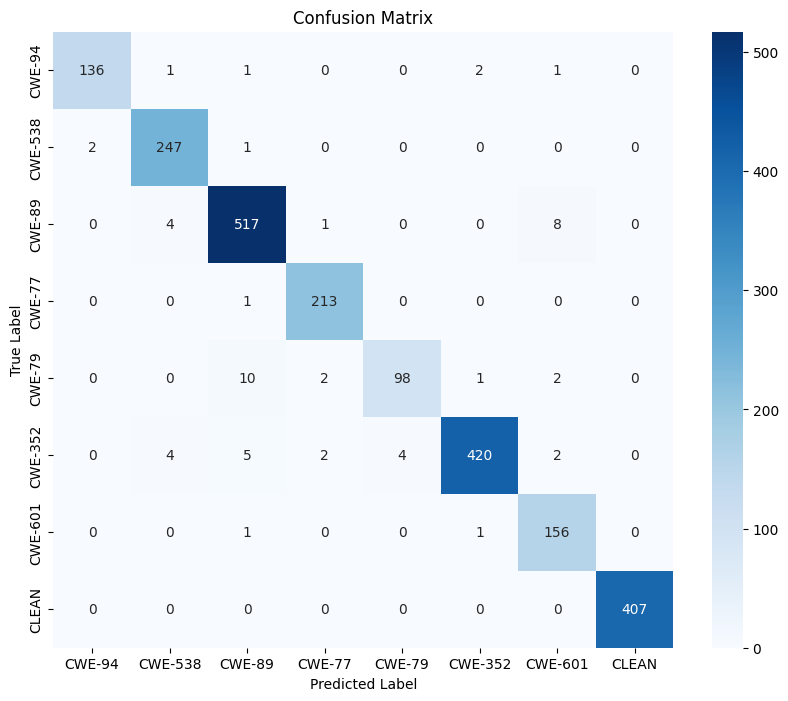

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix 생성
cm = confusion_matrix(test_truth, test_preds)

# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CWE_CLASSES, yticklabels=CWE_CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()